# Попытка деланья пробит модели с помощью Stan

## Загружаем библиотеки

In [1]:
#conda install pystan

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import pystan
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 8
%precision 4
plt.style.use('_classic_test_patch')

## Генерируем данные

Пусть будет 2 независимых переменных, одна из которых будет иметь нормальное распределение $\mathcal{N}(3, 4)$, другая -- равномерное $U(1, 3)$. Коэффициенты будут 2 (константа), -1 (для нормально распределенной случайной величины) и 0.5 (для равномерной случайной величины). Выборка будет состоять из 1000 объектов:

In [3]:
np.random.seed(999)

n = 1000
x_0 = np.ones(shape=n)
x_1 = np.random.normal(loc=3, scale=2, size=n)
x_2 = np.random.uniform(low=1, high=3, size=n)
X = np.vstack((x_0, x_1, x_2)).T

betas = np.array([2, -1, 0.5])
eps = np.random.normal(loc=0, scale=1, size=n) # предпосылка пробита

y = (X @ betas + eps > 0) * 1
print(f'Доля единиц в целевой переменной: {np.mean(y)}')

Доля единиц в целевой переменной: 0.508


## Модель

In [4]:
%%time

probit_data = {'n': n,
               'y': y,
               'x_1': x_1,
               'x_2': x_2
               } 

model = pystan.stan(file = '/Users/markymark/Desktop/Статистика/py/probit_norm_fast.stan',
              data = probit_data, 
              chains = 1,
              iter = 2000, 
              seed=999)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.


CPU times: user 5.34 s, sys: 81.3 ms, total: 5.42 s
Wall time: 47 s


In [5]:
print(model)

Inference for Stan model: anon_model_34d4a97a88d2fcdff1c95f422eb46b0b.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0   2.28    0.02   0.26   1.75   2.13   2.29   2.44    2.8    292    1.0
beta1  -0.96  2.9e-3   0.06  -1.08   -1.0  -0.96  -0.92  -0.85    376    1.0
beta2   0.32  5.3e-3    0.1   0.12   0.25   0.31   0.38   0.53    362    1.0
lp__  -330.3    0.08   1.32 -333.8 -330.8 -329.9 -329.3 -328.8    299    1.0

Samples were drawn using NUTS at Thu Jan 20 23:23:57 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


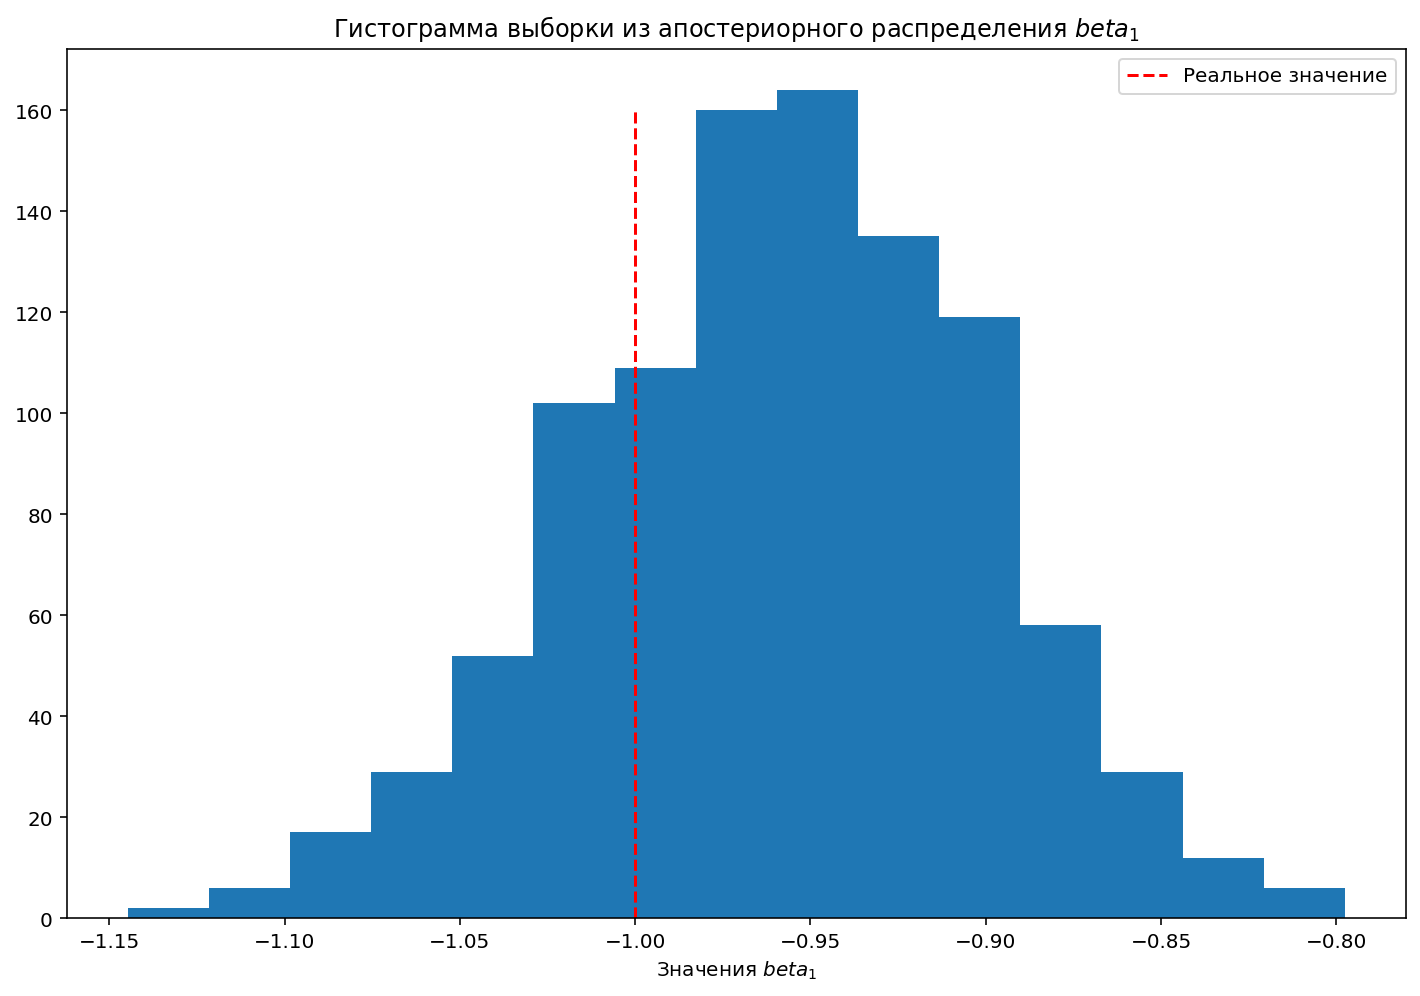

In [6]:
plt.title('Гистограмма выборки из апостериорного распределения $beta_1$')
plt.hist(model.extract()['beta1'], bins=15)
plt.xlabel('Значения $beta_1$')
plt.vlines(-1, 0, 160, 'r', '--', label="Реальное значение")
plt.legend();

Вроде получилось, теперь сделаем 100 симуляций, но сперва напишем функции, чтоб все было полаконичнее:

In [7]:
# функция для генерации выборки
def generate_sample(size=n):
    x_0 = np.ones(shape=size)
    x_1 = np.random.normal(loc=3, scale=2, size=size)
    x_2 = np.random.uniform(low=1, high=3, size=size)
    X = np.vstack((x_0, x_1, x_2)).T
    
    betas = np.array([2, -1, 0.5])
    eps = np.random.normal(loc=0, scale=1, size=size) # предпосылка пробита

    y = (X @ betas + eps > 0) * 1

    probit_data = {'n': size,
                   'y': y,
                   'x_1': x_1,
                   'x_2': x_2
                  }
    
    return probit_data

print('Доля единиц в целевой переменной:', np.mean(generate_sample()['y']))

Доля единиц в целевой переменной: 0.49


In [8]:
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

params = ['beta0', 'beta1', 'beta2']

def summary(way, n_iter=100, est_func=np.mean, n=n):
    # сюда будем складывать оценки на симуляциях (по дефолту будет считаться как среднее)
    results = {'beta0': [],
               'beta1': [],
               'beta2': []
              }
    # сюда будем складывать метрики
    total = []
    # строим модели
    for epoch in tqdm(range(n_iter)):
        # генерируем данные
        data = generate_sample()
        # обучаемся
        fit = pystan.stan(file = way,
              data = data, 
              chains = 1,
              iter = 2000,
              seed=999)
        # записываем результаты
        for i in range(len(betas)):
            estimator = est_func(fit.extract()[params[i]]) 
            results[params[i]].append(estimator)
    # подсчитываем метрики
    for i in range(len(params)):
        true_coef = np.ones(shape=n_iter) * betas[i]
        total.append([params[i], 
                      mape(true_coef, results[params[i]]) * 100, # в процентах
                      mse(true_coef, results[params[i]], squared=False)])
    return total

In [9]:
np.random.seed(999)
results_norm_prior = summary(way='/Users/markymark/Desktop/Статистика/py/probit_norm_fast.stan')
results_norm_prior

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_34d4a97a88d2fcdff1c95f422eb46b0b NOW.


[['beta0', 9.930417994838201, 0.2605804208044805],
 ['beta1', 5.147445556201702, 0.06524124259182093],
 ['beta2', 15.982703282617258, 0.09910975500399809]]

In [10]:
np.random.seed(999)
results_uniform_prior = summary('/Users/markymark/Desktop/Статистика/py/probit_uniform_fast.stan')
results_uniform_prior

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ddf0f0890f5ca9ad6bbf8f08ec6f714 NOW.


[['beta0', 9.880313821195234, 0.2588104725114518],
 ['beta1', 5.147174020245449, 0.06530867928514388],
 ['beta2', 15.887770111485832, 0.09790853746725663]]

In [11]:
np.random.seed(999)
results_log_prior = summary(way='/Users/markymark/Desktop/Статистика/py/probit_logistic_fast.stan')
results_log_prior

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d2

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d2

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d2

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e1d26b106b20be2122c5d0f080da405c NOW.


[['beta0', 9.921316746135673, 0.26180309858448786],
 ['beta1', 5.191238630831184, 0.0658948607802334],
 ['beta2', 16.071726777468864, 0.09894236675735071]]

In [12]:
np.random.seed(999)
results_student_prior = summary(way='/Users/markymark/Desktop/Статистика/py/probit_student_fast.stan')
results_norm_prior

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d54

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d54

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d54

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d548822eb347897949e593dff45d5dc NOW.


[['beta0', 9.930417994838201, 0.2605804208044805],
 ['beta1', 5.147445556201702, 0.06524124259182093],
 ['beta2', 15.982703282617258, 0.09910975500399809]]

In [13]:
results_student_prior

[['beta0', 9.80421356411894, 0.2584773688806386],
 ['beta1', 5.096571535498505, 0.06519038117901978],
 ['beta2', 15.931866661109288, 0.0982774262309754]]

Кладем все в датасеты, чтобы было приятнее смотреть на результаты:

In [28]:
dfs = []
cols = ['Coef', 'Prior', 'MAPE (%)', 'RMSE']

for i in range(3):
    table = []
    table.append([params[i], 'Normal(0, 10)', results_norm_prior[i][1], results_norm_prior[i][2]])
    table.append([params[i], 'Uniform(-10, 10)', results_uniform_prior[i][1], results_uniform_prior[i][2]])
    table.append([params[i], 'Logistic(0, 20)', results_log_prior[i][1], results_log_prior[i][2]])
    table.append([params[i], 'Student(20, 0, 10)', results_student_prior[i][1], results_student_prior[i][2]])
    df = pd.DataFrame(table, columns=cols)
    dfs.append(df)

In [29]:
dfs[0]

,Coef,Prior,MAPE (%),RMSE
0,beta0,"Normal(0, 10)",9.930418,0.260580
1,beta0,"Uniform(-10, 10)",9.880314,0.258810
2,beta0,"Logistic(0, 20)",9.921317,0.261803
3,beta0,"Student(20, 0, 10)",9.804214,0.258477


In [30]:
dfs[1]

,Coef,Prior,MAPE (%),RMSE
0,beta1,"Normal(0, 10)",5.147446,0.065241
1,beta1,"Uniform(-10, 10)",5.147174,0.065309
2,beta1,"Logistic(0, 20)",5.191239,0.065895
3,beta1,"Student(20, 0, 10)",5.096572,0.065190


In [31]:
dfs[2]

,Coef,Prior,MAPE (%),RMSE
0,beta2,"Normal(0, 10)",15.982703,0.099110
1,beta2,"Uniform(-10, 10)",15.887770,0.097909
2,beta2,"Logistic(0, 20)",16.071727,0.098942
3,beta2,"Student(20, 0, 10)",15.931867,0.098277


Результаты очень похожие при разных априорных распределениях, но лучше всех себя показывал Стьюдент, хуже всех -- логистическое